In [ ]:
## Import necessary libraries here (You can add libraries you want to use here)
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
import copy
import math
%matplotlib inline

# Part 1: Epipolar Geometry


## Overview

An algorithm for automatically estimating homography with RANSAC. 

## Data



In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_
!unzip "/content/Part1_data.zip" -d "/content/"
# Load Matches
data = loadmat('/content/Part1_data/matches.mat')
r1 = data['r1']
r2 = data['r2']
c1 = data['c1']
c2 = data['c2']
matches = data['matches']

Downloading...
From: https://drive.google.com/uc?id=1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_
To: /content/Part1_data.zip
100% 157k/157k [00:00<00:00, 83.5MB/s]
Archive:  /content/Part1_data.zip
   creating: /content/Part1_data/
  inflating: /content/Part1_data/chapel00.png  
  inflating: /content/Part1_data/chapel01.png  
  inflating: /content/Part1_data/matches.mat  


In [ ]:
# Load Keypoints
x1 = c1[matches[:,0]-1]
y1 = r1[matches[:,0]-1]
x2 = c2[matches[:,1]-1]
y2 = r2[matches[:,1]-1]

## Helper Functions

In [ ]:
from scipy.ndimage import gaussian_filter as gf
from google.colab.patches import cv2_imshow

def show_image(img, scale=1.0):
    plt.figure(figsize=scale* plt.figaspect(1))
    plt.imshow(img, interpolation='nearest')
    plt.gray() 
    plt.axis('off')
    plt.show()


### Code

inliers shape (1, 134)
 Fundamental Matrix  [[ 3.87749474e-06 -6.58210789e-06 -5.13483144e-03]
 [ 2.55756760e-06  4.75347231e-07  4.87918111e-04]
 [ 3.68361090e-03 -1.57557062e-04  2.52571741e-02]]
Normalized fundamental matrix [[ 7.55134904e-04 -1.28185329e-03 -9.99998893e-01]
 [ 5.24172232e-03  9.74221829e-04  9.99985788e-01]
 [ 1.44314617e-01 -6.17268970e-03  9.89512602e-01]]


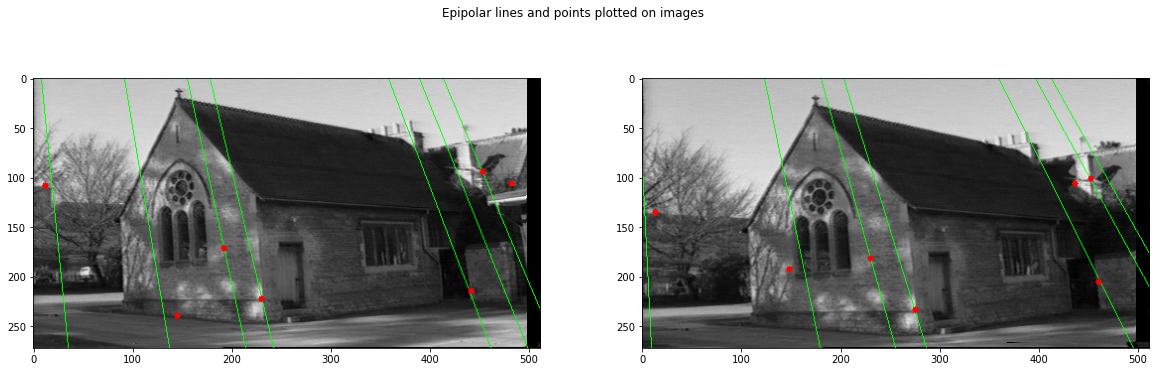

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
from sklearn.preprocessing import normalize
def drawlines(img1, img2, lines, pts1, pts2):
    # Drawing epilines on image
    r, c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
      
    for r, pt1, pt2 in zip(lines, pts1, pts2):

        x0, y0 = map(int, [0, -r[2] / r[1] ])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1] ])
          
        img1 = cv2.line(img1, (x0, y0), (x1, y1), (0, 255, 0), 1)
        img1 = cv2.circle(img1, tuple(pt1), 3, (255, 0, 0), -1)
        img2 = cv2.circle(img2, tuple(pt2), 3, (255, 0, 0), -1)

    return img1, img2

def normalize_coordinates(coordinates):
  # Find T matrix to normalize the coordinates
  coordinates = coordinates.T
  mean_x = np.mean(coordinates[:, 0])
  mean_y = np.mean(coordinates[:, 1])
  var_x = np.sqrt(np.var(coordinates[:, 0]))
  var_y = np.sqrt(np.var(coordinates[:, 1]))
  T = np.array([[1/var_x, 0, -mean_x/var_x],[0, 1/var_y, -mean_y/var_y], [0, 0, 1]])
  tmp_col = np.ones((np.size(coordinates[:, 0]),1))
  tmp_mat = np.array([coordinates[:,0], coordinates[:,1], tmp_col[:, 0]]) 
  new_coordinates = np.matmul(T, tmp_mat)
  return T, np.transpose(new_coordinates)

def computeA(U, X):
  # Constructing A matrix
  h, w = U.shape
  A = np.zeros(((h, 9)))
  A[:, 0] = U[:, 0]*X[:, 0]
  A[:, 1] = U[:, 0]*X[:, 1]
  A[:, 2] = U[:, 0]
  A[:, 3] = U[:, 1]*X[:, 0]
  A[:, 4] = U[:, 1]*X[:, 1]
  A[:, 5] = U[:, 1]
  A[:, 6] = X[:, 0]
  A[:, 7] = X[:, 1]
  A[:, 8] = np.ones((h))
  return A

def getInliers(pt1, pt2, F, thresh):
  # Function: implement the criteria checking inliers. 
  #     :
  U = pt1   # matches by 3
  X = pt2   # matches by 3

  U_est = np.transpose(np.matmul(F, X.T)) # points on img1  (a b c)   # matches by 3
  X_est = np.transpose(np.matmul(F.T, U.T))  # points on img2 (p q r) # matches by 3
  d1 = np.sum(U * U_est, axis = 1)  # (252)
  d2 = np.sum(X * X_est, axis = 1)  # (252)
  d1_div = np.sqrt(np.square(U_est[:, 0]) + np.square(U_est[:, 1]))
  d2_div = np.sqrt(np.square(X_est[:, 0]) + np.square(X_est[:, 1]))
  d1 = np.divide(d1, d1_div)
  d2 = np.divide(d2, d2_div)
  d = abs(d1) + abs(d2)
  inliers = np.where(d < thresh)
  inliers = np.asarray(inliers)
  return inliers

def evaluate(f, A):
  # Evaluates error for ransac
  # F is 9 *1 and A is (matches) by 9
  tmp = np.matmul(A, f)
  error = np.sum(np.square(tmp))
  return error

# def try_evaluate(pt1, pt2, F):
#   U = pt1   # matches by 3
#   X = pt2   # matches by 3

#   U_est = np.transpose(np.matmul(F, X.T)) # points on img1  (a b c)   # matches by 3
#   X_est = np.transpose(np.matmul(F.T, U.T))  # points on img2 (p q r) # matches by 3
#   d1 = np.sum(U * U_est, axis = 1)  # (252)
#   d2 = np.sum(X * X_est, axis = 1)  # (252)
#   d1_div = np.sqrt(np.square(U_est[:, 0]) + np.square(U_est[:, 1]))
#   d2_div = np.sqrt(np.square(X_est[:, 0]) + np.square(X_est[:, 1]))
#   d1 = np.divide(d1, d1_div)
#   d2 = np.divide(d2, d2_div)
#   d = abs(d1) + abs(d2)
#   thresh = 0.2
#   inliers = np.where(d < thresh)
#   inliers = np.asarray(inliers)
#   h, w = np.shape(inliers)
#   return h

def ransacF(A, T1, T2, U_all, X_all):
  # Find normalization matrix
  # Transform point set 1 and 2
  # RANSAC based 8-point algorithm
  #   : 
  # Initializations
  iterations = 5000
  min_error = 99999
  optimum_H = 0
  inliers = []

  for i in range(iterations):
    # randomly select 8 rows
    n_rows, n_cols = A.shape
    random_index = np.random.choice(n_rows, size=8, replace=False)

    # constructing temp A matrix from entire A using random indices
    A_temp = A[random_index, :]

    # Finding initial F
    U, S, V = np.linalg.svd(A_temp)
    f_lowest = V.T[:, 8]  #Lowest eigen vector
    F = np.reshape(f_lowest, (3, 3))

    # Resolve detF = 0
    U1, S1, V1 = np.linalg.svd(F)
    S1[2] = 0
    S1 = np.diag(S1)
    newF = np.matmul(U1, np.matmul(S1, V1))   

    # Look for inliers
    error = evaluate(newF.reshape(9, 1), A)
    # error = try_evaluate(U_all, X_all, newF)

    if error < min_error:
      optimum_F = newF
      F_vertical = newF.reshape(9, 1)
      min_error = error

  # Robust 
  threshold = 0.080
  # Get inliers
  inliers = getInliers(U_all, X_all, optimum_F, threshold)
  h1, w1 = inliers.shape
  print("inliers shape", inliers.shape)
  # Finding F for inliers
  A_robust = A[inliers[0, :], :]
  U2, S2, V2 = np.linalg.svd(A_robust)
  V_low = V2.T[:, 8]  # lowest eigen vector
  F_tmp = np.reshape(V_low, (3, 3))

  # DetF = 0 enforcement
  U3, S3, V3 = np.linalg.svd(F_tmp)
  S3[2] = 0
  S3 = np.diag(S3)
  newF = np.matmul(U3, np.matmul(S3, V3)) 

  F_end = np.matmul(np.transpose(T1), np.matmul(newF, T2))   # denormalizing
  print(" Fundamental Matrix ", F_end)
  F_normed = normalize(F_end, axis=1, norm='l2')
  print("Normalized fundamental matrix", F_normed)
  return F_end

def Normalize(x, y):
  # Function: find the transformation to make it zero mean and the variance as sqrt(2)
  #   : 
  coordinates = np.vstack((x.T, y.T))
  T, X = normalize_coordinates(coordinates)
  return T, X

def computeF(x1, y1, x2, y2):
  #  Function: compute fundamental matrix from corresponding points
  #   : 
  # Normalize keypoints and find their corresponding T matrix
  T1, U = Normalize(x1, y1) # U is 252 by 3
  T2, X = Normalize(x2, y2) # X is 252 by 3

  # Compute A to solve Ax=0
  A = computeA(U, X)
  F = ransacF(A, T1, T2, U, X)
  
  return F

# main
F = computeF(x1, y1, x2, y2)

# Plotting epilines for randomly selected 7 key points
n_rows, n_cols = x1.shape

random_index = np.random.choice(n_rows, size=7, replace=False)

temp = np.ones((n_rows, 1))
U = np.hstack((x1, y1))
U = np.hstack((U, temp))
X = np.hstack((x2, y2))
X = np.hstack((X, temp))
U_temp = U[random_index, :]
X_temp = X[random_index, :]

# Compute epilines
l1 = np.transpose(np.matmul(F, X_temp.T)) # epilines associated with U
l2 = np.transpose(np.matmul(F.T, U_temp.T))  # epilines associated with X

# Reading images and computing epilines
imgLeft = cv2.imread("/content/Part1_data/chapel00.png")
imgLeft = cv2.cvtColor(imgLeft, cv2.COLOR_BGR2GRAY)
imgRight = cv2.imread("/content/Part1_data/chapel01.png")
imgRight = cv2.cvtColor(imgRight, cv2.COLOR_BGR2GRAY)
img5, img6 = drawlines(imgLeft, imgRight, l1, np.int32(U_temp[:, 0:2]),np.int32(X_temp[:, 0:2]))
img3, img4 = drawlines(imgRight, imgLeft, l2, np.int32(X_temp[:, 0:2]), np.int32(U_temp[:, 0:2]))

# Plot final images
fig = plt.figure(figsize = (20, 6))
fig.suptitle("Epipolar lines and points plotted on images")
ax = fig.add_subplot(1, 2, 1)
plt.imshow(img5)
ax = fig.add_subplot(1, 2, 2)
plt.imshow(img3)


*   To decide between inlier and outlier, the Fundamental matrix F is found. If U are the normalized coordinates of image 1 and X are the normalized coordinates of image 2, FX is the line associated with X and (F.T)U is the line associated with U. The distance between FX and U and the distance between (F.T)U and X is to be found. For a single set of coordinates of FX (a, b, c) and of U (u, v) d1 is calculated as abs(au + bv + c)/ sqrt(a^2 + b^2). Similarly, the distance d2 between (F.T)U and X is also found. Then d is taken as d1 + d2. A threshold is used to find the locations where d < threshold, and these points will be the inliers. 
*   The fundamental matrix F after normalizing to unit length is printed above. 
* Corresponding epipolar lines and the points on each image are displayed above.




# Part 2: Image stitching



## Overview
An algorithm for automatically estimating the fundamental matrix F using RANSAC and the normalized 8-point algorithm. 

Image Stitching Algorithm Overview
1. Detect keypoints
2. Match keypoints
3. Estimate homography with matched keypoints (using RANSAC)
4. Combine images


## Data



In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
!unzip "/content/hill.zip" -d "/content/hill"

!gdown 1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
!unzip "/content/tv.zip" -d "/content/tv"


Downloading...
From: https://drive.google.com/uc?id=1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
To: /content/hill.zip
100% 205k/205k [00:00<00:00, 69.9MB/s]
Archive:  /content/hill.zip
  inflating: /content/hill/1.JPG     
  inflating: /content/hill/2.JPG     
  inflating: /content/hill/3.JPG     
Downloading...
From: https://drive.google.com/uc?id=1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
To: /content/tv.zip
100% 130k/130k [00:00<00:00, 60.4MB/s]
Archive:  /content/tv.zip
  inflating: /content/tv/1.jpg       
  inflating: /content/tv/2.jpg       
  inflating: /content/tv/3.jpg       


## Helper Functions

In [ ]:
import cv2
from numpy.lib.shape_base import get_array_prepare

def drawMatches(image1, kp1, image2, kp2, idx_pairs):
    keypt1 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp1.tolist()]
    keypt2 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp2.tolist()]
    matches = [cv2.DMatch(pair[0], pair[1], 0) for pair in idx_pairs.tolist()]
    return cv2.drawMatches(image1, keypt1, image2, keypt2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

def plot_matches(images, feature_coord, matches, img_idx):
    matched_img = drawMatches(images[img_idx], feature_coord[img_idx], images[img_idx-1], 
                              feature_coord[img_idx-1], matches[img_idx-1])

    cv2.imshow('Matches Found', matched_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def est_homography(src, dest):
    N = src.shape[0]
    if N != dest.shape[0]:
        raise ValueError("src and diff should have the same dimension")
    src_h = np.hstack((src, np.ones((N, 1))))
    A = np.array([np.block([[src_h[n], np.zeros(3), -dest[n, 0] * src_h[n]],
                            [np.zeros(3), src_h[n], -dest[n, 1] * src_h[n]]])
                  for n in range(N)]).reshape(2 * N, 9)
    [_, _, V] = np.linalg.svd(A)
    return V.T[:, 8].reshape(3, 3)

def apply_homography(H, src):
    src_h = np.hstack((src, np.ones((src.shape[0], 1))))
    dest =  src_h @ H.T
    return (dest / dest[:,[2]])[:,0:2]

def readImages(folder, num_images):
  arr_images = []

  if folder =='/content/hill/':
    for i in range(num_images):
      arr_images.append(cv2.imread(f'{folder}{i+1}.JPG'))
    
  else:
    for i in range(num_images):
      arr_images.append(cv2.imread(f'{folder}{i+1}.jpg'))

  return np.array(arr_images)

  #return np.array(arr_images, dtype=np.float32)

### Code

 Stitching Image 0 and 1
SIFT matches  52
Best Homography after RANSAC [[5.84713460e-01 1.07033433e-02 2.21588955e-02]
 [3.16399253e-03 5.74581994e-01 1.20668765e-03]
 [2.18167088e-02 1.64181011e-04 5.71727786e-01]]
inliers shape (1, 104)
Denormalized Homography matrix  [[-6.34120946e-01 -7.48575662e-03  1.70206169e+02]
 [-1.49389011e-01 -5.83929805e-01  5.70426595e+01]
 [-4.94644138e-04 -1.13432609e-05 -3.96281067e-01]]

 Stitching Image 1 and 2
SIFT matches  62
Best Homography after RANSAC [[ 0.57168758 -0.00971149 -0.02159632]
 [ 0.0168932   0.57721255 -0.01254447]
 [-0.02155497  0.00203774  0.58183052]]
inliers shape (1, 124)
Denormalized Homography matrix  [[-4.53057093e-01  8.61754982e-03 -1.31632411e+02]
 [ 1.08162972e-01 -5.70134130e-01 -1.64774276e+01]
 [ 3.61834316e-04  1.19221036e-05 -6.27782100e-01]]

Stitching blended images- im0-im1 with im1-im2 
SIFT matches  408
Best Homography after RANSAC [[ 5.77343581e-01  2.29411427e-06  7.14082711e-06]
 [ 3.00141294e-06  5.77358878

Text(0.5, 1.0, 'Final Stitched Image')

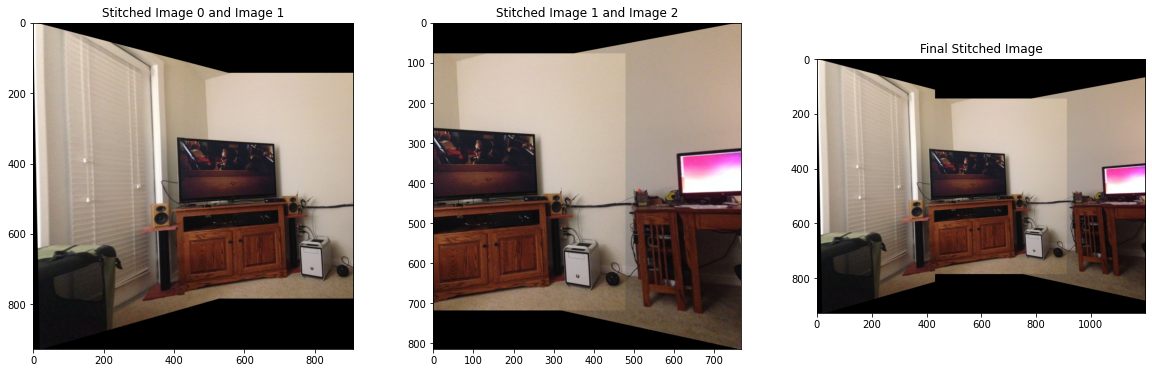

In [ ]:
from IPython.core import error
from sklearn.metrics import mean_squared_error
#   : 

def FindMatches(BaseImage, SecImage, sift_threshold ):
  # Using SIFT to find the keypoints and decriptors in the images
  Sift = cv2.SIFT_create()
  BaseImage_kp, BaseImage_des = Sift.detectAndCompute(cv2.cvtColor(BaseImage, cv2.COLOR_BGR2GRAY), None)
  SecImage_kp, SecImage_des = Sift.detectAndCompute(cv2.cvtColor(SecImage, cv2.COLOR_BGR2GRAY), None)
  # Using Brute Force matcher to find matches.
  BF_Matcher = cv2.BFMatcher()
  InitialMatches = BF_Matcher.knnMatch(BaseImage_des, SecImage_des, k=2)
  # Applying ratio test and filtering out the good matches
  GoodMatches = []
  
  for m, n in InitialMatches:
      if m.distance < sift_threshold * n.distance:
          GoodMatches.append([m])

  return GoodMatches, BaseImage_kp, SecImage_kp

def normalize_coordinates(coordinates):
  # Find T matrix to normalize the coordinates
  mean_x = np.mean(coordinates[:, 0])
  mean_y = np.mean(coordinates[:, 1])
  var_x = np.sqrt(np.var(coordinates[:, 0]))
  var_y = np.sqrt(np.var(coordinates[:, 1]))
  T = np.array([[1/var_x, 0, -mean_x/var_x],[0, 1/var_y, -mean_y/var_y], [0, 0, 1]])
  tmp_col = np.ones((np.size(coordinates[:, 0]),1))
  tmp_mat = np.array([coordinates[:,0], coordinates[:,1], tmp_col[:, 0]]) 
  new_coordinates = np.matmul(T, tmp_mat)
  return T, np.transpose(new_coordinates)

def evaluate_all(H_vert, A, threshold):
  # Finds inliers and their locations
  errors = np.matmul(A, H_vert)
  errors = np.square(errors)
  inliers = np.where(errors < threshold)
  inliers = np.asarray(inliers)
  return inliers

def evaluate(H, A):
  # Evaluates error for ransac
  # H is 9 *1 and A is (2 * matches) by 9
  tmp = np.matmul(A, H)
  error = np.sum(np.square(tmp))
  return error

def get_totalA(base_kps, sec_kps):
  # Get A matrix for the given pair of keypoints
  h, w = base_kps.shape
  at1 = np.zeros((2*h, 3))
  at2 = np.zeros((2*h, 3))

  for i in range(h):
    at1[2*i, :]= base_kps[i, :] 
    at1[(2*i) + 1, :]= np.zeros((1, 3))
    at2[2*i, :]= np.zeros((1, 3))
    at2[(2*i) + 1, :]= base_kps[i, :] 

  a1 = -1 * np.hstack((at1, at2))
  a2 = np.zeros((2*h, 3))

  for i in range(h):
    a2[2*i, 0]= base_kps[i, 0] * sec_kps[i, 0]
    a2[(2*i) + 1, 0]= base_kps[i, 0] * sec_kps[i, 1]
    a2[2*i, 1]= base_kps[i, 1] * sec_kps[i, 0]
    a2[(2*i) + 1, 1]= base_kps[i, 1] * sec_kps[i, 1]
    a2[2*i, 2]= sec_kps[i, 0]
    a2[(2*i) + 1, 2]= sec_kps[i, 1]
  A = np.hstack((a1, a2))
  return A


def find_homography_ransac(BaseImage_pts, SecImage_pts, ransac_threshold):
  # Normalizing coordinates
  T_sec, norm_SecImage_kps = normalize_coordinates(SecImage_pts)
  T_base, norm_BaseImage_kps = normalize_coordinates(BaseImage_pts) # keypts by 3

  # Initializations
  iterations = 200
  min_error = 99999
  optimum_H = 0
  inliers = []

  # Get entire A matrix (2*matches by 9)
  A = get_totalA(norm_BaseImage_kps, norm_SecImage_kps)

  for i in range(iterations):
    # randomly select 4 rows
    n_rows, n_cols = norm_SecImage_kps.shape
    random_index = np.random.choice(n_rows, size=4, replace=False)

    # constructing temp A matrix from entire A using random indices
    A_temp = A[[2 * random_index[0],2 * random_index[0] +1, 2* random_index[1],2* random_index[1] +1, 2* random_index[2], 2* random_index[2] + 1, 2* random_index[3], 2* random_index[3] + 1], :]
    
    # Finding homography
    U, S, V = np.linalg.svd(A_temp)
    V_lowest = V.T[:, 8]  #Lowest eigen vector
    H = np.reshape(V_lowest, (3, 3))
    error = evaluate(V_lowest, A)
    if error < min_error:
      optimum_H = H
      H_vertical = V_lowest
      min_error = error
      
  print("Best Homography after RANSAC", optimum_H)
  # Robust 
  threshold = 0.3
  # find inliers
  inliers = evaluate_all(H_vertical, A, threshold)
  h1, w1 = inliers.shape
  print("inliers shape", inliers.shape)
  A_robust = A[inliers[0, :], :]
  U1, S1, V1 = np.linalg.svd(A_robust)
  V_low = V1.T[:, 8]  # lowest eigen vector
  H_final = np.reshape(V_low, (3, 3))
  H_end = np.matmul(np.linalg.inv(T_sec), np.matmul(H_final, T_base))   # denormalizing

  return H_end

def FindHomography( Matches, BaseImage_kp, SecImage_kp):
    # If less than 4 matches found, exit the code.
    if len(Matches) < 4:
        print("\nNot enough matches found between the images.\n")
        exit(0)

    # Storing coordinates of points corresponding to the matches found in both the images
    print("SIFT matches ", len(Matches))
    BaseImage_pts = []
    SecImage_pts = []
    for Match in Matches:
        BaseImage_pts.append(BaseImage_kp[Match[0].queryIdx].pt)
        SecImage_pts.append(SecImage_kp[Match[0].trainIdx].pt)

    # Changing the datatype to "float32" for finding homography
    BaseImage_pts = np.float32(BaseImage_pts)
    SecImage_pts = np.float32(SecImage_pts)
    # print(BaseImage_pts.shape)
    # print(SecImage_pts.shape)

    # Finding the homography matrix
    H_matrix = find_homography_ransac(BaseImage_pts, SecImage_pts, 4.0)
    print("Denormalized Homography matrix ", H_matrix)
    return H_matrix

def GetNewFrameSizeAndMatrix(HomographyMatrix, Sec_ImageShape, Base_ImageShape):
  # Refered : https://github.com/KEDIARAHUL135/PanoramaStitching/blob/0db55c4b989efddba751b3e9cf8b57bd7df19f0d/main.py#L50
    # Finding size of the image
    (Height, Width) = Sec_ImageShape
    
    # Taking the matrix of initial coordinates of the corners of the secondary image
    InitialMatrix = np.array([[0, Width - 1, Width - 1, 0],
                              [0, 0, Height - 1, Height - 1],
                              [1, 1, 1, 1]])
    
    # Finding the final coordinates of the corners of the image after transformation
    FinalMatrix = np.dot(HomographyMatrix, InitialMatrix)

    [x, y, c] = FinalMatrix
    x = np.divide(x, c)
    y = np.divide(y, c)

    # Finding the dimentions of the stitched image frame and the "Correction" factor
    min_x, max_x = int(round(min(x))), int(round(max(x)))
    min_y, max_y = int(round(min(y))), int(round(max(y)))

    New_Width = max_x
    New_Height = max_y
    Correction = [0, 0]
    if min_x < 0:
        New_Width -= min_x
        Correction[0] = abs(min_x)
    if min_y < 0:
        New_Height -= min_y
        Correction[1] = abs(min_y)
    
    # Correcting New_Width and New_Height
    if New_Width < Base_ImageShape[1] + Correction[0]:
        New_Width = Base_ImageShape[1] + Correction[0]
    if New_Height < Base_ImageShape[0] + Correction[1]:
        New_Height = Base_ImageShape[0] + Correction[1]

    # Finding the coordinates of the corners of the image if they all were within the frame.
    x = np.add(x, Correction[0])
    y = np.add(y, Correction[1])
    OldInitialPoints = np.float32([[0, 0],
                                   [Width - 1, 0],
                                   [Width - 1, Height - 1],
                                   [0, Height - 1]])
    NewFinalPonts = np.float32(np.array([x, y]).transpose())

    # Updating the homography matrix
    HomographyMatrix = cv2.getPerspectiveTransform(OldInitialPoints, NewFinalPonts)
    
    return [New_Height, New_Width], Correction, HomographyMatrix

def plot_stitched(HomographyMatrix, BaseImage, SecImage):
  # Finding size of new frame of stitched images and updating the homography matrix 
  NewFrameSize, Correction, HomographyMatrix = GetNewFrameSizeAndMatrix(HomographyMatrix, SecImage.shape[:2], BaseImage.shape[:2])

  # Placing the images upon one another.
  StitchedImage = cv2.warpPerspective(SecImage, HomographyMatrix, (NewFrameSize[1], NewFrameSize[0]))
  StitchedImage[Correction[1]:Correction[1]+BaseImage.shape[0], Correction[0]:Correction[0]+BaseImage.shape[1]] = BaseImage

  return StitchedImage

# Reading image sequence
folder = '/content/tv/'
im = readImages(folder, 3) 
sift_threshold = 0.40
# Stitch image 0 and 1
# Detecting corners
Matches, BaseImage_kp, SecImage_kp = FindMatches(im[0], im[1], sift_threshold)
print(" Stitching Image 0 and 1")
# Finding homography matrix
h1 = FindHomography(Matches, BaseImage_kp, SecImage_kp)
# Plotting stitched image
StitchedImage1 = plot_stitched(h1, im[1], im[0])

# Stitch image 2 and 1
# Detecting corners
Matches1, BaseImage_kp1, SecImage_kp1 = FindMatches(im[2], im[1], sift_threshold)
print("")
print(" Stitching Image 1 and 2")
# Finding homography matrix
h2 = FindHomography(Matches1, BaseImage_kp1, SecImage_kp1)
StitchedImage2 = plot_stitched(h2, im[1], im[2])

# Stitch all images( im0-im1 with im1-im2)
# Detecting corners
Matches2, BaseImage_kp2, SecImage_kp2 = FindMatches(StitchedImage1, StitchedImage2, sift_threshold)
print("")
print("Stitching blended images- im0-im1 with im1-im2 ")
# Finding homography matrix
h3 = FindHomography(Matches2, BaseImage_kp2, SecImage_kp2)
# Plotting stitched image
final_stitched = plot_stitched(h3, StitchedImage2, StitchedImage1)

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].imshow(StitchedImage1[:,:, ::-1])
ax[1].imshow(StitchedImage2[:,:, ::-1])
ax[2].imshow(final_stitched[:,:, ::-1])
ax[0].set_title('Stitched Image 0 and Image 1')
ax[1].set_title('Stitched Image 1 and Image 2')
ax[2].set_title('Final Stitched Image')

 Stitching Image 0 and 1
SIFT matches  107
Best Homography after RANSAC [[ 0.57826764 -0.02040281  0.00935413]
 [ 0.02620967  0.57488645  0.00092379]
 [ 0.0098534  -0.00168643  0.5777721 ]]
inliers shape (1, 214)
Denormalized Homography matrix  [[ 5.97407916e-01 -3.20643932e-02 -8.66683448e+01]
 [ 5.85115078e-02  5.67907521e-01 -1.65754392e+00]
 [ 1.87831961e-04 -4.63229999e-05  5.32145012e-01]]

 Stitching Image 1 and 2
SIFT matches  203
Best Homography after RANSAC [[ 5.78322417e-01  4.46452128e-03 -7.91561173e-03]
 [-2.80277323e-05  5.76499511e-01  1.02886458e-03]
 [-7.78194558e-03  1.44999944e-03  5.77100673e-01]]
inliers shape (1, 406)
Denormalized Homography matrix  [[-5.34199093e-01 -1.14784520e-02 -8.07199093e+01]
 [ 2.88093371e-02 -5.81684835e-01  9.29014589e+00]
 [ 1.66867952e-04 -2.85699536e-05 -5.94730638e-01]]

Stitching blended images- im0-im1 with im1-im2 
SIFT matches  1414
Best Homography after RANSAC [[ 5.77352628e-01 -1.49280555e-07 -1.18692932e-06]
 [-1.12864413e-06

Text(0.5, 1.0, 'Final Stitched Image')

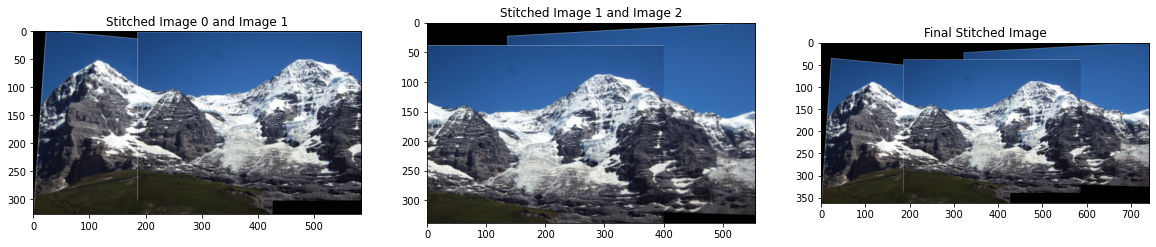

In [ ]:
# Reading image sequence
folder = '/content/hill/'
im = readImages(folder, 3) 
sift_threshold = 0.15
# Stitch image 0 and 1
# Detecting corners
Matches, BaseImage_kp, SecImage_kp = FindMatches(im[0], im[1], sift_threshold)
print(" Stitching Image 0 and 1")
# Finding homography matrix
h1 = FindHomography(Matches, BaseImage_kp, SecImage_kp)
# Plotting stitched image
StitchedImage1 = plot_stitched(h1, im[1], im[0])

# Stitch image 2 and 1
# Detecting corners
Matches1, BaseImage_kp1, SecImage_kp1 = FindMatches(im[2], im[1], sift_threshold)
print("")
print(" Stitching Image 1 and 2")
# Finding homography matrix
h2 = FindHomography(Matches1, BaseImage_kp1, SecImage_kp1)
StitchedImage2 = plot_stitched(h2, im[1], im[2])

# Stitch all images( im0-im1 with im1-im2)
# Detecting corners
Matches2, BaseImage_kp2, SecImage_kp2 = FindMatches(StitchedImage1, StitchedImage2, sift_threshold)
print("")
print("Stitching blended images- im0-im1 with im1-im2 ")
# Finding homography matrix
h3 = FindHomography(Matches2, BaseImage_kp2, SecImage_kp2)
# Plotting stitched image
final_stitched = plot_stitched(h3, StitchedImage2, StitchedImage1)

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].imshow(StitchedImage1[:,:, ::-1])
ax[1].imshow(StitchedImage2[:,:, ::-1])
ax[2].imshow(final_stitched[:,:, ::-1])
ax[0].set_title('Stitched Image 0 and Image 1')
ax[1].set_title('Stitched Image 1 and Image 2')
ax[2].set_title('Final Stitched Image')



*   To remove the incorrect matches with RANSAC, for every iteration, a matrix H is calculated. Then the matrix A is multiplied by H, the reshaped 9 by 1 matrix. The result is squared and added column wise. This result should ideally be zero, so the result obtained is the sqared distance. This result is saved as the minimum distance. For every iteration, it is checked if the obtained result is less than the minimum distance. The homograhpy obtaned through RANSAC corressponds to the result H with the minimum distance in all the iterations. The H obtained through RANSAC is used to find the inliers. If U are the normalized coordinates of image 1 and X are the normalized coordinates of image 2, then ideally X=HU. The inliers locations are found by using a threshold to find the coordinates where squared sum of H_ransac*U - X is less than threshold. Then the final homography is calculated only using inliers.
*   The best Homography after RANSAC is displayed above.
* The blended images for both hill and tv sequences are displayed above. 



# Part 3: Affine Structure from Motion

## Overview
Recover a 3D pointcloud from the image sequence hotel.seq0.png … hotel.seq50.png. 

## Data


In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
!unzip "/content/Part2_data.zip" -d "/content/"
# Load Matches
data = loadmat('/content/Part2_data/tracks.mat')

Downloading...
From: https://drive.google.com/uc?id=1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
To: /content/Part2_data.zip
100% 5.44M/5.44M [00:00<00:00, 265MB/s]
Archive:  /content/Part2_data.zip
   creating: /content/Part2_data/
   creating: /content/Part2_data/images/
  inflating: /content/Part2_data/images/hotel.seq0.png  
  inflating: /content/Part2_data/images/hotel.seq1.png  
  inflating: /content/Part2_data/images/hotel.seq10.png  
  inflating: /content/Part2_data/images/hotel.seq11.png  
  inflating: /content/Part2_data/images/hotel.seq12.png  
  inflating: /content/Part2_data/images/hotel.seq13.png  
  inflating: /content/Part2_data/images/hotel.seq14.png  
  inflating: /content/Part2_data/images/hotel.seq15.png  
  inflating: /content/Part2_data/images/hotel.seq16.png  
  inflating: /content/Part2_data/images/hotel.seq17.png  
  inflating: /content/Part2_data/images/hotel.seq18.png  
  inflating: /content/Part2_data/images/hotel.seq19.png  
  inflating: /content/Part2_data/images/hot

### Code

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[ 0.1541005   0.20594941 -0.27957266]


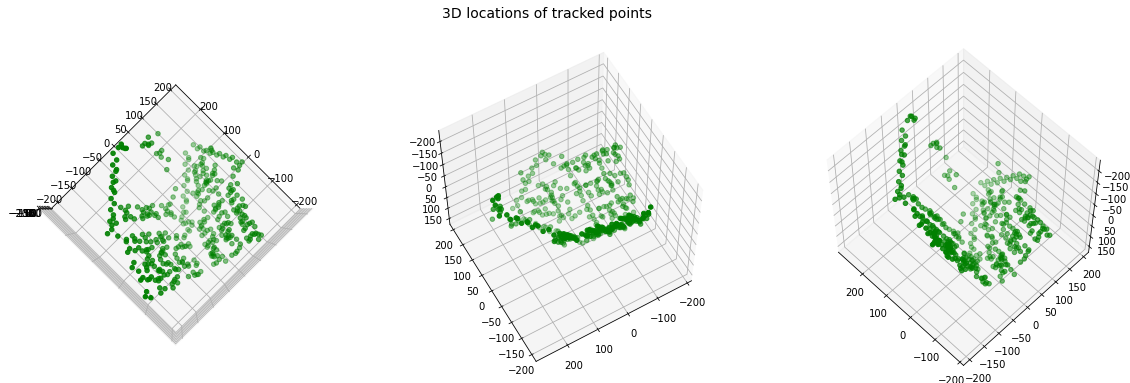

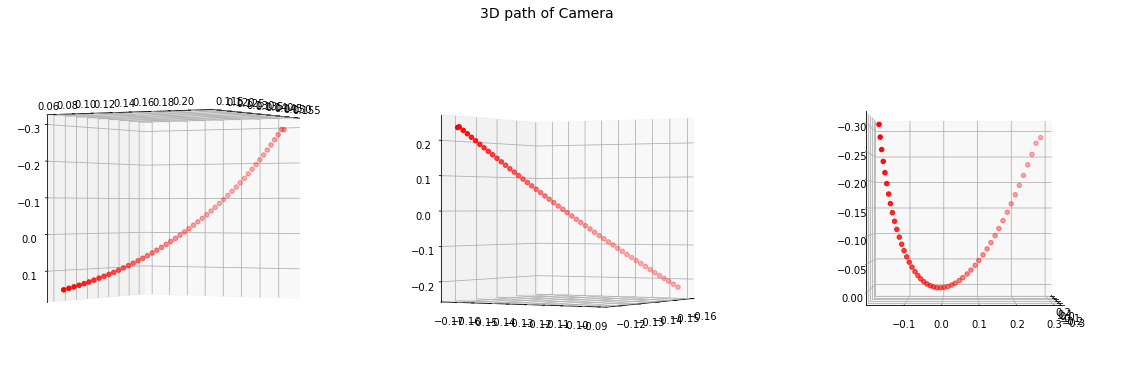

In [ ]:
from mpl_toolkits import mplot3d
def plot_3d_coord(S):
  # Plot 3d point cloud
  fig = plt.figure(figsize = (20, 6))
  fig.suptitle("3D locations of tracked points", fontsize=14)
  ax = fig.add_subplot(1, 3, 1, projection='3d')
  ax.scatter3D(S[0, :], S[1, :], S[2, :], color = 'green')
  ax.view_init( -90, 45)

  ax = fig.add_subplot(1, 3, 2, projection='3d')
  ax.scatter3D(S[0, :], S[1, :], S[2, :], color = 'green')
  ax.view_init( -120, 120)

  ax = fig.add_subplot(1, 3, 3, projection='3d')
  ax.scatter3D(S[0, :], S[1, :], S[2, :], color = 'green')
  ax.view_init( -120, 45)
  return None

def plot_camera_path(A):
  # Plot camera path
  p1 = np.zeros((51, 3))
  p2 = np.zeros((51, 3))
  p3 = np.zeros((51, 3))
  for i in range(51):
    A_temp = A[(2*i):(2*i)+2, :]
    A_cross = np.matmul(A_temp[0, :].reshape(3, 1), np.transpose(A_temp[1, :].reshape(3, 1)))
    p1[i, :]= A_cross[0, :]
    p2[i, :]= A_cross[1, :]
    p3[i, :]= A_cross[2, :]

  p1 = normalize(p1, axis=0, norm='l2')
  p2 = normalize(p2, axis=0, norm='l2')
  p3 = normalize(p3, axis=0, norm='l2')

  print(p1[2, :])
  fig = plt.figure(figsize = (20, 6))

  ax = fig.add_subplot(1, 3, 1, projection='3d')
  ax.scatter3D(p1[:, 0], p1[:,1], p1[:, 2],  color='red')
  ax.view_init( -180, -30)

  ax = fig.add_subplot(1, 3, 2, projection='3d')
  ax.scatter3D(p2[:, 0], p2[:,1], p2[:,2], color='red')
  ax.view_init( 0, 30)

  ax = fig.add_subplot(1, 3, 3, projection='3d')
  ax.scatter3D(p3[:, 0], p3[:, 1], p3[:, 2], color='red')
  ax.view_init( -180, 0)
  fig.suptitle("3D path of Camera", fontsize=14)
  return None

def remove_NAN(track_x, track_y, frames):
  ## Removing points that moved out the frame
  newx = []
  newy = []

  for i in range(track_x.shape[0]):
    flag = 0
    for j in range(frames):
      if math.isnan(track_x[i][j]) or math.isnan(track_y[i][j]):
        flag = 1
        break

    if flag == 0:
      newx.append(track_x[i, :])
      newy.append(track_y[i, :])

  return np.array(newx), np.array(newy)

def center_coordinates(x_pts, y_pts):
  # Centering the data
  mean_x = np.mean(x_pts, axis = 0)
  mean_y = np.mean(y_pts, axis = 0)
  x_pts = x_pts - mean_x
  y_pts = y_pts - mean_y
  return x_pts, y_pts

def create_D(xpts, ypts):
  # creating D matrix of size 102 by 400
  xpts = np.transpose(xpts)
  ypts = np.transpose(ypts)
  h, w = np.shape(xpts)
  D = np.zeros((2*h, w))
  for i in range(h):
    D[2*i, :]= xpts[i, :]
    D[(2*i) + 1, :] = ypts[i, :]

  return D

def affineSFM(x, y):
  '''
  Function: Affine structure from motion algorithm
  % Normalize x, y to zero mean
  % Create measurement matrix
  D = [xn' ; yn'];
  % Decompose and enforce rank 3
  % Apply orthographic constraints
  '''
  #      
  # Removing NaN
  frames = 51
  x, y = remove_NAN(x, y, frames)
  # NOrmalizing coordinates
  xpts, ypts = center_coordinates(x, y)
  # Creating D matrix 
  D = create_D(xpts, ypts)
  # Decomposing D
  U, W, V = np.linalg.svd(D)

  # Enforcing rank 3
  Utmp = U[:, 0:3]
  Wtmp = np.diagflat(W[0:3])
  Vtmp = V.T[:, 0:3]

  # Estimating new A and S
  A = np.matmul(Utmp, np.sqrt(Wtmp)) # 102 by 3
  S = np.matmul(np.sqrt(Wtmp), Vtmp.T) # 400 by 3

  o_mat = np.array([1, 1, 0]).reshape(3, 1)   # initializing b matrix
  h, w = A.shape
  hnew = int(3*h/2)
  A_final = np.zeros((hnew, 9))
  b_final = np.zeros((hnew, 1))

  # Applying orthographic constraints
  for i in range(51):
    A_ext = A[2*i:(2*i)+2, :]   
    r1 = A_ext[0, :].reshape(1, 3)
    r2 = A_ext[1, :].reshape(1, 3)
    A_final[3*i, :] = np.matmul(r1.T, r1).reshape(1, 9)
    A_final[(3*i) +1, :] = np.matmul(r2.T, r2).reshape(1, 9)
    A_final[(3*i) +2, :] = np.matmul(r1.T, r2).reshape(1, 9)
    b_final[(3*i):(3*i)+3, :] = o_mat
    
  # Solving for L using least squares
  f = np.linalg.lstsq(A_final, b_final, rcond=None)[0]
  L = f.reshape(3,3)

  # Obtaining C from L
  C = np.linalg.cholesky(L)

  # Updating A and S
  A_found = np.matmul(A, C) # 102 by 3
  S_found = np.matmul(np.linalg.inv(C), S)    # new S 3 by 400

  return A_found, S_found

# Read image and features
im = readImages(folder, 51)
track_x = data['track_x']
track_y = data['track_y']

# Finding affine transform
A, X = affineSFM(track_x, track_y)
plot_3d_coord(X)  # Plotting 3d cloud
plot_camera_path(A) # Plotting camera path


*   Reference: 
    - Tomasi and Kanade. Shape and Motion from Image Streams under Orthography: a Factorization Method. 1992